In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error,mean_absolute_error
import math
import torch.nn.functional as F
from transformers import T5Tokenizer,AutoTokenizer,BertTokenizer,AutoModel
import re
from sklearn.model_selection import train_test_split

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df=pd.read_csv('/kaggle/input/peptide/data.csv')

In [3]:
df.shape

(134281, 4)

In [4]:
df['mhc'].value_counts()

mhc
QEFFIASGAAVDAIMWLFLECYDLQRATYHVGFT    10412
QEFFIASGAAVDAIMWGYFELYVIDRQTVHVGFT     6325
QEFFIASGAAVDAIMEVHFDYYDLQKATYHVGFT     6317
QEFFIASGAAVDAIMESSFDYFDFDRATYHVGFT     6045
QEFFIASGAAVDAIMESSYDYFDLQKRNYHVVFT     5352
                                      ...  
QEFFIASGAAVDAIMESGFDYYDFDRLTYHVVFT        3
QEFFIASGAAVDAIMQDYFHGYDFDRATYHVGFT        2
QEFFIASGAAVDAIMEVHFDYYSLQRETYHVVFT        2
QEFFIASGAAVDAIMESSFEYYDLQRATYHVGFT        1
QEFFIASGAAVDAIMWPRFDHFDIQAATYHVVFT        1
Name: count, Length: 75, dtype: int64

In [5]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",do_lower_case=False)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
df.count()

pep       134281
logic     134281
allele    134281
mhc       134281
dtype: int64

In [6]:
pep_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['pep']]
mhc_sequences = [" ".join(list(re.sub(r"[UZOB]", "X", data))) for data in df['mhc']]

In [7]:
pep_ids = tokenizer(pep_sequences, add_special_tokens=True, padding="longest")
mhc_ids = tokenizer(mhc_sequences, add_special_tokens=True, padding="longest")

In [11]:
tokenizer.get_vocab()

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
pep_input_ids = torch.tensor(pep_ids['input_ids']).to(device)
pep_attention_mask = torch.tensor(pep_ids['attention_mask']).to(device)
mhc_input_ids = torch.tensor(mhc_ids['input_ids']).to(device)
mhc_attention_mask = torch.tensor(mhc_ids['attention_mask']).to(device)


In [14]:
pep_input_ids[0],pep_attention_mask[0]

(tensor([ 0, 14, 15, 19,  7, 15, 16, 17, 11,  4, 15,  4,  5, 11,  2,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [15]:
mhc_input_ids[100],mhc_attention_mask[100]

(tensor([ 0, 19,  5, 18, 18, 20, 18,  8,  6,  6,  5, 12,  4, 17, 11,  4, 18,  6,
         16, 18,  9, 19, 18, 13, 12,  9,  9,  7, 10, 20, 21,  4,  6, 20, 11,  2],
        device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'))

In [58]:
scores = torch.tensor(df['logic'].values,dtype=torch.float32).to(device)

In [16]:
pep_input_ids.shape

torch.Size([134281, 39])

In [17]:
mhc_input_ids.shape

torch.Size([134281, 36])

In [12]:
extra_pad = pep_input_ids.size(1)-mhc_input_ids.size(1)
extra_pad

3

In [13]:
mhc_input_ids = F.pad(mhc_input_ids, (0, extra_pad), value = 1)
mhc_attention_mask = F.pad(mhc_attention_mask, (0, extra_pad), value = 0)

In [20]:
mhc_input_ids[120],mhc_attention_mask[120]

(tensor([ 0, 19,  5, 18, 18, 20, 18,  8,  6,  6,  5, 12,  4, 17, 11,  4, 18,  6,
         16, 18,  9, 19, 18, 13, 12,  9,  9,  7, 10, 20, 21,  4,  6, 20, 11,  2,
          1,  1,  1], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0'))

In [21]:
#X_pep = torch.stack((pep_input_ids,pep_attention_mask),dim=1).to(device)
#X_mhc = torch.stack((mhc_input_ids,mhc_attention_mask),dim=1)

In [59]:
y = scores


In [60]:
y.shape

torch.Size([134281])

In [56]:
#model.to(device)

EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
    

In [57]:
''''pep_dataset = TensorDataset(X_pep[:, 0], X_pep[:, 1])
batch_size = 4
data_loader = DataLoader(pep_dataset, batch_size=batch_size, shuffle=False)
model.eval()
all_embeddings_pep = []
with torch.no_grad():
    for input_ids, attention_mask in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state
        cls_embeddings = batch_embeddings[:, 0, :]
        all_embeddings_pep.append(cls_embeddings)
all_embeddings_pep = torch.cat(all_embeddings_pep, dim=0)'''

In [58]:
'''np.save('/content/drive/MyDrive/tensor_data_pep_cls_balanced.npy', all_embeddings_pep.cpu())
loaded_tensor = np.load('/content/drive/MyDrive/tensor_data_pep_cls_balanced.npy')'''

In [59]:
'''all_embeddings_pep.cpu() == loaded_tensor'''

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [60]:
'''mhc_dataset = TensorDataset(X_mhc[:, 0], X_mhc[:, 1])
batch_size = 32
data_loader = DataLoader(mhc_dataset, batch_size=batch_size, shuffle=False)
model.eval()
all_embeddings_mhc = []
with torch.no_grad():
    for input_ids, attention_mask in data_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state
        cls_embeddings = batch_embeddings[:, 0, :]
        all_embeddings_mhc.append(cls_embeddings)

# Combine all embeddings into a single tensor
all_embeddings_mhc = torch.cat(all_embeddings_mhc, dim=0)  # Shape: (num_samples, hidden_dim)'''

In [61]:
#all_embeddings_mhc.shape

torch.Size([134281, 320])

In [173]:
#np.save('/content/drive/MyDrive/tensor_data_mhc_cls_balanced.npy', all_embeddings_mhc.cpu())
#loaded_tensor = np.load('/content/drive/MyDrive/tensor_data_mhc_cls.npy')

KeyboardInterrupt: 

In [63]:
#all_embeddings_mhc.cpu() == loaded_tensor

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [16]:
pep_embeddings = torch.tensor(np.load('/kaggle/input/bioembeds1/tensor_data_pep_cls.npy'))

In [17]:
file_path = '/kaggle/input/bioembeds1/tensor_data_mhc_cls.npy'
mhc_embeddings = torch.tensor(np.load(file_path))

In [18]:
X = torch.stack((pep_embeddings,mhc_embeddings),dim=1)
y = scores

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [21]:
X_train.shape,X_test.shape,X_val.shape

(torch.Size([85939, 2, 320]),
 torch.Size([26857, 2, 320]),
 torch.Size([21485, 2, 320]))

In [22]:
y_train.shape,y_test.shape,y_val.shape

(torch.Size([85939]), torch.Size([26857]), torch.Size([21485]))

In [23]:
train_dataset = TensorDataset(X_train[: ,0],X_train[:,1], y_train)
val_dataset = TensorDataset(X_val[:,0],X_val[:,1], y_val)
test_dataset = TensorDataset(X_test[:,0],X_test[:,1],y_test)

In [24]:
#train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
#val_loader = DataLoader(val_dataset,batch_size=128,shuffle=False)

In [27]:
class TransformerEncoder(nn.Module):
    def __init__(self, model_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)


class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(CrossAttentionLayer, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, query, key, value):
        attn_output, _ = self.multihead_attn(query, key, value)
        attn_output = self.norm1(attn_output + query)
        ffn_output = self.ffn(attn_output)
        output = self.norm2(ffn_output + attn_output)

        return output


class SequenceModel(nn.Module):
    def __init__(self, model_dim, num_heads, num_layers, ffdim, dropout=0.1): # Add ffdim to the __init__ parameters
        super(SequenceModel, self).__init__()
        self.encoder_pep = TransformerEncoder(model_dim, num_heads, num_layers, dropout)
        self.encoder_mhc = TransformerEncoder(model_dim, num_heads, num_layers, dropout)
        self.cross_attention = CrossAttentionLayer(model_dim, num_heads, ffdim, dropout) # Use ffdim here
        self.fc1 = nn.Linear(model_dim, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, pep_cls, mhc_cls):
        pep_refined = self.encoder_pep(pep_cls.unsqueeze(1)).squeeze(1)
        mhc_refined = self.encoder_mhc(mhc_cls.unsqueeze(1)).squeeze(1)
        cross_output = self.cross_attention(pep_refined.unsqueeze(1), mhc_refined.unsqueeze(1), mhc_refined.unsqueeze(1))
        cross_output = cross_output.squeeze(1)
        x = F.relu(self.fc1(cross_output))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [28]:
torch.manual_seed(3407)

In [150]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00


In [37]:
import optuna
from optuna.trial import TrialState
import torch
from torch import nn
from torch.optim import AdamW
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameter suggestions
    model_dim = 320
    num_heads = trial.suggest_categorical("num_heads", [4, 8])
    num_layers = trial.suggest_categorical("num_layers", [2, 3, 4])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    ffdim = trial.suggest_categorical("ffdim", [256, 512])
    lr = trial.suggest_categorical("learning_rate", [1e-4, 5e-4, 1e-3])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128,256])
    loss_function = trial.suggest_categorical("loss_function", ["mse", "huber"])

    # Initialize the model
    model = SequenceModel(
        model_dim=model_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        ffdim=ffdim,
        dropout=dropout
    ).to(device)

    # Select loss function
    if loss_function == "mse":
        criterion = nn.MSELoss()
    elif loss_function == "huber":
        criterion = nn.HuberLoss(delta=1.0)  # Adjust delta if needed

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Adjust DataLoader batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(5):
        # Training loop for 1 epoch
        model.train()
        train_loss = 0
        for pep_ids, mhc_ids, scores in train_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0
        total_val_preds = []
        total_val_labels = []
        with torch.no_grad():
            for pep_ids, mhc_ids, scores in val_loader:
                pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
                outputs = model(pep_ids, mhc_ids)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()
                total_val_preds.append(outputs.cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)

        # Compute metrics
        total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
        total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
        val_r2 = r2_score(total_val_labels, total_val_preds)
        val_mse = mean_squared_error(total_val_labels, total_val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(total_val_labels, total_val_preds)

        print(f"Trial Results: Val Loss: {val_loss:.4f}, Val R^2: {val_r2:.4f}, Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")

    # Optuna minimizes the objective, so return validation loss
    return val_loss

# Create and run the Optuna study
study = optuna.create_study(direction="minimize")  # Set direction to "minimize" since we optimize val_loss
study.optimize(objective, n_trials=20)

# Print the best trial
print("Best trial:")
trial = study.best_trial

print(f"  Val Loss: {trial.value:.4f}")
print(f"  Hyperparameters: {trial.params}")

# Save the best hyperparameters to a file or dictionary if needed
best_hyperparams = trial.params


[I 2025-01-19 02:36:41,480] A new study created in memory with name: no-name-5b75eb88-ebf2-4cb3-b936-2b3be0e9fe0b


Trial Results: Val Loss: 0.0345, Val R^2: -0.0065, Val MSE: 0.0690, Val RMSE: 0.2627, Val MAE: 0.2204
Trial Results: Val Loss: 0.0343, Val R^2: -0.0000, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0346, Val R^2: -0.0086, Val MSE: 0.0692, Val RMSE: 0.2630, Val MAE: 0.2207
Trial Results: Val Loss: 0.0344, Val R^2: -0.0032, Val MSE: 0.0688, Val RMSE: 0.2623, Val MAE: 0.2190


[I 2025-01-19 02:37:36,610] Trial 0 finished with value: 0.03429143853662979 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.001, 'weight_decay': 7.890895816973526e-05, 'batch_size': 256, 'loss_function': 'huber'}. Best is trial 0 with value: 0.03429143853662979.


Trial Results: Val Loss: 0.0343, Val R^2: -0.0000, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2192
Trial Results: Val Loss: 0.0348, Val R^2: -0.0153, Val MSE: 0.0696, Val RMSE: 0.2639, Val MAE: 0.2216
Trial Results: Val Loss: 0.0343, Val R^2: -0.0000, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0343, Val R^2: -0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0343, Val R^2: -0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191


[I 2025-01-19 02:43:20,376] Trial 1 finished with value: 0.03432754760918518 and parameters: {'num_heads': 8, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 256, 'learning_rate': 0.001, 'weight_decay': 1.0647894216716345e-05, 'batch_size': 32, 'loss_function': 'huber'}. Best is trial 0 with value: 0.03429143853662979.


Trial Results: Val Loss: 0.0343, Val R^2: -0.0007, Val MSE: 0.0686, Val RMSE: 0.2620, Val MAE: 0.2190
Trial Results: Val Loss: 0.0702, Val R^2: -0.0231, Val MSE: 0.0702, Val RMSE: 0.2649, Val MAE: 0.2227
Trial Results: Val Loss: 0.0710, Val R^2: -0.0353, Val MSE: 0.0710, Val RMSE: 0.2665, Val MAE: 0.2241
Trial Results: Val Loss: 0.0687, Val R^2: -0.0011, Val MSE: 0.0687, Val RMSE: 0.2620, Val MAE: 0.2195
Trial Results: Val Loss: 0.0688, Val R^2: -0.0030, Val MSE: 0.0688, Val RMSE: 0.2623, Val MAE: 0.2190


[I 2025-01-19 02:47:57,828] Trial 2 finished with value: 0.06862159603874066 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'ffdim': 512, 'learning_rate': 0.001, 'weight_decay': 0.00123636068806752, 'batch_size': 32, 'loss_function': 'mse'}. Best is trial 0 with value: 0.03429143853662979.


Trial Results: Val Loss: 0.0686, Val R^2: -0.0003, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2190
Trial Results: Val Loss: 0.0274, Val R^2: 0.2008, Val MSE: 0.0548, Val RMSE: 0.2341, Val MAE: 0.1908
Trial Results: Val Loss: 0.0240, Val R^2: 0.3006, Val MSE: 0.0480, Val RMSE: 0.2190, Val MAE: 0.1766
Trial Results: Val Loss: 0.0227, Val R^2: 0.3384, Val MSE: 0.0454, Val RMSE: 0.2130, Val MAE: 0.1712
Trial Results: Val Loss: 0.0223, Val R^2: 0.3484, Val MSE: 0.0447, Val RMSE: 0.2114, Val MAE: 0.1700


[I 2025-01-19 02:48:55,921] Trial 3 finished with value: 0.021311128417783903 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.00039119612094049635, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0213, Val R^2: 0.3785, Val MSE: 0.0426, Val RMSE: 0.2064, Val MAE: 0.1648
Trial Results: Val Loss: 0.0561, Val R^2: 0.1818, Val MSE: 0.0561, Val RMSE: 0.2369, Val MAE: 0.1951
Trial Results: Val Loss: 0.0546, Val R^2: 0.2036, Val MSE: 0.0546, Val RMSE: 0.2337, Val MAE: 0.1930
Trial Results: Val Loss: 0.0551, Val R^2: 0.1962, Val MSE: 0.0551, Val RMSE: 0.2348, Val MAE: 0.1933
Trial Results: Val Loss: 0.0558, Val R^2: 0.1861, Val MSE: 0.0558, Val RMSE: 0.2363, Val MAE: 0.1950


[I 2025-01-19 02:50:45,764] Trial 4 finished with value: 0.053957683843604866 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0005, 'weight_decay': 2.4180572171514096e-05, 'batch_size': 64, 'loss_function': 'mse'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0540, Val R^2: 0.2131, Val MSE: 0.0540, Val RMSE: 0.2323, Val MAE: 0.1909
Trial Results: Val Loss: 0.0354, Val R^2: -0.0319, Val MSE: 0.0708, Val RMSE: 0.2660, Val MAE: 0.2237
Trial Results: Val Loss: 0.0349, Val R^2: -0.0189, Val MSE: 0.0699, Val RMSE: 0.2643, Val MAE: 0.2221
Trial Results: Val Loss: 0.0343, Val R^2: -0.0002, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2190
Trial Results: Val Loss: 0.0344, Val R^2: -0.0044, Val MSE: 0.0689, Val RMSE: 0.2625, Val MAE: 0.2201


[I 2025-01-19 02:53:49,809] Trial 5 finished with value: 0.034397982365806545 and parameters: {'num_heads': 4, 'num_layers': 4, 'dropout': 0.3, 'ffdim': 512, 'learning_rate': 0.001, 'weight_decay': 0.003749926660797669, 'batch_size': 64, 'loss_function': 'huber'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0344, Val R^2: -0.0033, Val MSE: 0.0688, Val RMSE: 0.2623, Val MAE: 0.2199
Trial Results: Val Loss: 0.0281, Val R^2: 0.1796, Val MSE: 0.0563, Val RMSE: 0.2372, Val MAE: 0.1915
Trial Results: Val Loss: 0.0254, Val R^2: 0.2589, Val MSE: 0.0508, Val RMSE: 0.2254, Val MAE: 0.1830
Trial Results: Val Loss: 0.0259, Val R^2: 0.2453, Val MSE: 0.0518, Val RMSE: 0.2275, Val MAE: 0.1844
Trial Results: Val Loss: 0.0256, Val R^2: 0.2539, Val MSE: 0.0512, Val RMSE: 0.2262, Val MAE: 0.1826


[I 2025-01-19 02:54:27,632] Trial 6 finished with value: 0.024048263916657084 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.3, 'ffdim': 256, 'learning_rate': 0.0005, 'weight_decay': 0.008537151869923168, 'batch_size': 256, 'loss_function': 'huber'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0240, Val R^2: 0.2987, Val MSE: 0.0481, Val RMSE: 0.2193, Val MAE: 0.1777
Trial Results: Val Loss: 0.0294, Val R^2: 0.1420, Val MSE: 0.0588, Val RMSE: 0.2426, Val MAE: 0.1993
Trial Results: Val Loss: 0.0250, Val R^2: 0.2708, Val MSE: 0.0500, Val RMSE: 0.2236, Val MAE: 0.1804
Trial Results: Val Loss: 0.0233, Val R^2: 0.3214, Val MSE: 0.0465, Val RMSE: 0.2157, Val MAE: 0.1727
Trial Results: Val Loss: 0.0236, Val R^2: 0.3115, Val MSE: 0.0472, Val RMSE: 0.2173, Val MAE: 0.1715


[I 2025-01-19 02:55:27,841] Trial 7 finished with value: 0.021846306970387343 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.00034767544190931777, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0218, Val R^2: 0.3629, Val MSE: 0.0437, Val RMSE: 0.2090, Val MAE: 0.1684
Trial Results: Val Loss: 0.0686, Val R^2: -0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0686, Val R^2: -0.0007, Val MSE: 0.0686, Val RMSE: 0.2620, Val MAE: 0.2194
Trial Results: Val Loss: 0.0688, Val R^2: -0.0030, Val MSE: 0.0688, Val RMSE: 0.2623, Val MAE: 0.2190
Trial Results: Val Loss: 0.0687, Val R^2: -0.0018, Val MSE: 0.0687, Val RMSE: 0.2621, Val MAE: 0.2190


[I 2025-01-19 02:59:01,224] Trial 8 finished with value: 0.06860948106207486 and parameters: {'num_heads': 4, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.001, 'weight_decay': 0.008899453766259998, 'batch_size': 32, 'loss_function': 'mse'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0686, Val R^2: -0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191
Trial Results: Val Loss: 0.0688, Val R^2: -0.0035, Val MSE: 0.0688, Val RMSE: 0.2623, Val MAE: 0.2199
Trial Results: Val Loss: 0.0686, Val R^2: -0.0004, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2193
Trial Results: Val Loss: 0.0686, Val R^2: -0.0001, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2192
Trial Results: Val Loss: 0.0686, Val R^2: -0.0000, Val MSE: 0.0686, Val RMSE: 0.2619, Val MAE: 0.2191


[I 2025-01-19 03:03:44,658] Trial 9 finished with value: 0.06868018004267167 and parameters: {'num_heads': 4, 'num_layers': 3, 'dropout': 0.3, 'ffdim': 512, 'learning_rate': 0.0005, 'weight_decay': 0.007755408706235109, 'batch_size': 32, 'loss_function': 'mse'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0687, Val R^2: -0.0011, Val MSE: 0.0687, Val RMSE: 0.2620, Val MAE: 0.2195
Trial Results: Val Loss: 0.0253, Val R^2: 0.2612, Val MSE: 0.0507, Val RMSE: 0.2251, Val MAE: 0.1824
Trial Results: Val Loss: 0.0235, Val R^2: 0.3161, Val MSE: 0.0469, Val RMSE: 0.2166, Val MAE: 0.1731
Trial Results: Val Loss: 0.0244, Val R^2: 0.2887, Val MSE: 0.0488, Val RMSE: 0.2209, Val MAE: 0.1778
Trial Results: Val Loss: 0.0237, Val R^2: 0.3096, Val MSE: 0.0473, Val RMSE: 0.2176, Val MAE: 0.1704


[I 2025-01-19 03:04:44,725] Trial 10 finished with value: 0.02258883791399144 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.00026847034778984313, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0226, Val R^2: 0.3413, Val MSE: 0.0452, Val RMSE: 0.2126, Val MAE: 0.1670
Trial Results: Val Loss: 0.0250, Val R^2: 0.2696, Val MSE: 0.0501, Val RMSE: 0.2238, Val MAE: 0.1829
Trial Results: Val Loss: 0.0233, Val R^2: 0.3204, Val MSE: 0.0466, Val RMSE: 0.2159, Val MAE: 0.1744
Trial Results: Val Loss: 0.0235, Val R^2: 0.3150, Val MSE: 0.0470, Val RMSE: 0.2167, Val MAE: 0.1762
Trial Results: Val Loss: 0.0220, Val R^2: 0.3582, Val MSE: 0.0440, Val RMSE: 0.2098, Val MAE: 0.1682


[I 2025-01-19 03:05:43,881] Trial 11 finished with value: 0.02144306748440223 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.0003612391659013412, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0214, Val R^2: 0.3747, Val MSE: 0.0429, Val RMSE: 0.2071, Val MAE: 0.1648
Trial Results: Val Loss: 0.0243, Val R^2: 0.2919, Val MSE: 0.0486, Val RMSE: 0.2204, Val MAE: 0.1792
Trial Results: Val Loss: 0.0243, Val R^2: 0.2921, Val MSE: 0.0485, Val RMSE: 0.2203, Val MAE: 0.1759
Trial Results: Val Loss: 0.0226, Val R^2: 0.3419, Val MSE: 0.0451, Val RMSE: 0.2125, Val MAE: 0.1704
Trial Results: Val Loss: 0.0233, Val R^2: 0.3209, Val MSE: 0.0466, Val RMSE: 0.2158, Val MAE: 0.1750


[I 2025-01-19 03:06:43,795] Trial 12 finished with value: 0.021390730276748184 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.0004628138359825489, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 3 with value: 0.021311128417783903.


Trial Results: Val Loss: 0.0214, Val R^2: 0.3762, Val MSE: 0.0428, Val RMSE: 0.2068, Val MAE: 0.1633
Trial Results: Val Loss: 0.0239, Val R^2: 0.3039, Val MSE: 0.0477, Val RMSE: 0.2185, Val MAE: 0.1774
Trial Results: Val Loss: 0.0237, Val R^2: 0.3090, Val MSE: 0.0474, Val RMSE: 0.2177, Val MAE: 0.1762
Trial Results: Val Loss: 0.0233, Val R^2: 0.3214, Val MSE: 0.0465, Val RMSE: 0.2157, Val MAE: 0.1710
Trial Results: Val Loss: 0.0222, Val R^2: 0.3517, Val MSE: 0.0445, Val RMSE: 0.2109, Val MAE: 0.1681


[I 2025-01-19 03:07:41,651] Trial 13 finished with value: 0.021309892597076083 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.0008297675718617075, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 13 with value: 0.021309892597076083.


Trial Results: Val Loss: 0.0213, Val R^2: 0.3785, Val MSE: 0.0426, Val RMSE: 0.2064, Val MAE: 0.1647
Trial Results: Val Loss: 0.0254, Val R^2: 0.2595, Val MSE: 0.0508, Val RMSE: 0.2254, Val MAE: 0.1817
Trial Results: Val Loss: 0.0232, Val R^2: 0.3240, Val MSE: 0.0464, Val RMSE: 0.2153, Val MAE: 0.1730
Trial Results: Val Loss: 0.0232, Val R^2: 0.3247, Val MSE: 0.0463, Val RMSE: 0.2152, Val MAE: 0.1736
Trial Results: Val Loss: 0.0227, Val R^2: 0.3366, Val MSE: 0.0455, Val RMSE: 0.2133, Val MAE: 0.1703


[I 2025-01-19 03:08:40,748] Trial 14 finished with value: 0.0208967754207108 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.0012688100052200243, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 14 with value: 0.0208967754207108.


Trial Results: Val Loss: 0.0209, Val R^2: 0.3906, Val MSE: 0.0418, Val RMSE: 0.2044, Val MAE: 0.1632
Trial Results: Val Loss: 0.0254, Val R^2: 0.2604, Val MSE: 0.0507, Val RMSE: 0.2252, Val MAE: 0.1853
Trial Results: Val Loss: 0.0240, Val R^2: 0.3011, Val MSE: 0.0479, Val RMSE: 0.2189, Val MAE: 0.1785
Trial Results: Val Loss: 0.0231, Val R^2: 0.3257, Val MSE: 0.0462, Val RMSE: 0.2150, Val MAE: 0.1723
Trial Results: Val Loss: 0.0219, Val R^2: 0.3605, Val MSE: 0.0439, Val RMSE: 0.2094, Val MAE: 0.1675


[I 2025-01-19 03:09:58,514] Trial 15 finished with value: 0.021626774005458822 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.2, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.001503439575815471, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 14 with value: 0.0208967754207108.


Trial Results: Val Loss: 0.0216, Val R^2: 0.3693, Val MSE: 0.0433, Val RMSE: 0.2080, Val MAE: 0.1673
Trial Results: Val Loss: 0.0241, Val R^2: 0.2977, Val MSE: 0.0482, Val RMSE: 0.2195, Val MAE: 0.1779
Trial Results: Val Loss: 0.0226, Val R^2: 0.3395, Val MSE: 0.0453, Val RMSE: 0.2128, Val MAE: 0.1707
Trial Results: Val Loss: 0.0215, Val R^2: 0.3722, Val MSE: 0.0431, Val RMSE: 0.2075, Val MAE: 0.1642
Trial Results: Val Loss: 0.0214, Val R^2: 0.3772, Val MSE: 0.0427, Val RMSE: 0.2067, Val MAE: 0.1650


[I 2025-01-19 03:10:58,120] Trial 16 finished with value: 0.019983842830351067 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.0015724491637962514, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 16 with value: 0.019983842830351067.


Trial Results: Val Loss: 0.0200, Val R^2: 0.4172, Val MSE: 0.0400, Val RMSE: 0.1999, Val MAE: 0.1580
Trial Results: Val Loss: 0.0241, Val R^2: 0.2981, Val MSE: 0.0481, Val RMSE: 0.2194, Val MAE: 0.1762
Trial Results: Val Loss: 0.0236, Val R^2: 0.3112, Val MSE: 0.0472, Val RMSE: 0.2173, Val MAE: 0.1728
Trial Results: Val Loss: 0.0219, Val R^2: 0.3605, Val MSE: 0.0439, Val RMSE: 0.2094, Val MAE: 0.1662
Trial Results: Val Loss: 0.0209, Val R^2: 0.3894, Val MSE: 0.0419, Val RMSE: 0.2046, Val MAE: 0.1632


[I 2025-01-19 03:11:57,743] Trial 17 finished with value: 0.02028834482189268 and parameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.003221808356616506, 'batch_size': 128, 'loss_function': 'huber'}. Best is trial 16 with value: 0.019983842830351067.


Trial Results: Val Loss: 0.0203, Val R^2: 0.4083, Val MSE: 0.0406, Val RMSE: 0.2014, Val MAE: 0.1598
Trial Results: Val Loss: 0.0501, Val R^2: 0.2695, Val MSE: 0.0501, Val RMSE: 0.2238, Val MAE: 0.1831
Trial Results: Val Loss: 0.0457, Val R^2: 0.3334, Val MSE: 0.0457, Val RMSE: 0.2138, Val MAE: 0.1733
Trial Results: Val Loss: 0.0485, Val R^2: 0.2924, Val MSE: 0.0485, Val RMSE: 0.2203, Val MAE: 0.1781
Trial Results: Val Loss: 0.0429, Val R^2: 0.3751, Val MSE: 0.0429, Val RMSE: 0.2070, Val MAE: 0.1640


[I 2025-01-19 03:14:23,578] Trial 18 finished with value: 0.04100450542977169 and parameters: {'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'ffdim': 512, 'learning_rate': 0.0001, 'weight_decay': 0.003025491635704351, 'batch_size': 64, 'loss_function': 'mse'}. Best is trial 16 with value: 0.019983842830351067.


Trial Results: Val Loss: 0.0410, Val R^2: 0.4020, Val MSE: 0.0410, Val RMSE: 0.2025, Val MAE: 0.1602
Trial Results: Val Loss: 0.0245, Val R^2: 0.2865, Val MSE: 0.0489, Val RMSE: 0.2212, Val MAE: 0.1794
Trial Results: Val Loss: 0.0227, Val R^2: 0.3386, Val MSE: 0.0454, Val RMSE: 0.2130, Val MAE: 0.1720
Trial Results: Val Loss: 0.0223, Val R^2: 0.3499, Val MSE: 0.0446, Val RMSE: 0.2111, Val MAE: 0.1674
Trial Results: Val Loss: 0.0213, Val R^2: 0.3775, Val MSE: 0.0427, Val RMSE: 0.2066, Val MAE: 0.1635


[I 2025-01-19 03:15:24,529] Trial 19 finished with value: 0.021203801146752778 and parameters: {'num_heads': 8, 'num_layers': 4, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.003174642898861854, 'batch_size': 256, 'loss_function': 'huber'}. Best is trial 16 with value: 0.019983842830351067.


Trial Results: Val Loss: 0.0212, Val R^2: 0.3816, Val MSE: 0.0424, Val RMSE: 0.2059, Val MAE: 0.1621
Best trial:
  Val Loss: 0.0200
  Hyperparameters: {'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'ffdim': 256, 'learning_rate': 0.0001, 'weight_decay': 0.0015724491637962514, 'batch_size': 128, 'loss_function': 'huber'}


In [25]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128,shuffle=False)

In [45]:
model_dim = 320
num_heads = 8
num_layers = 2
dropout = 0.1
ffdim = 256
model = SequenceModel(model_dim, num_heads, num_layers,ffdim,dropout=dropout).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001 ,weight_decay=0.0015724491637962514)
epochs = 200

In [46]:
model.to(device)

SequenceModel(
  (encoder_pep): TransformerEncoder(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
      )
      (linear1): Linear(in_features=320, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=320, bias=True)
      (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
          )
          (linear1): Linear(in_features=320, out_fea

In [47]:
patience = 10
best_val_r2 = 0
patience_counter = 0
save_path = '/kaggle/working/pepesmclshyperparamtuned.pth'
train_losses = []
val_losses = []
val_r2_list = []
train_mse_list = []
val_mse_list = []
train_rmse_list = []
val_rmse_list = []
train_mae_list = []
val_mae_list = []
train_r2_list = []

for epoch in range(epochs):
    # train loop
    model.train()
    train_loss = 0
    total_train_preds = []
    total_train_labels = []

    for pep_ids, mhc_ids, scores in train_loader:
        pep_ids,  mhc_ids, scores = pep_ids.to(device),mhc_ids.to(device),scores.to(device)
        optimizer.zero_grad()
        outputs = model(pep_ids,  mhc_ids)
        loss = criterion(outputs.squeeze(), scores)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_train_preds.append(outputs.detach().cpu())
        total_train_labels.append(scores.detach().cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    total_train_preds = torch.cat(total_train_preds, dim=0).numpy().flatten()
    total_train_labels = torch.cat(total_train_labels, dim=0).numpy().flatten()
    train_r2 = r2_score(total_train_labels, total_train_preds)
    train_mse = mean_squared_error(total_train_labels, total_train_preds)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(total_train_labels, total_train_preds)

    train_r2_list.append(train_r2)
    train_mse_list.append(train_mse)
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train R^2: {train_r2:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

    # val loop
    model.eval()
    val_loss = 0
    total_val_preds = []
    total_val_labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, scores in val_loader:
            pep_ids, mhc_ids, scores = (
                pep_ids.to(device),
                mhc_ids.to(device),
                scores.to(device)
            )
            outputs = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            val_loss += loss.item()
            total_val_preds.append(outputs.cpu())
            total_val_labels.append(scores.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    total_val_preds = torch.cat(total_val_preds, dim=0).numpy().flatten()
    total_val_labels = torch.cat(total_val_labels, dim=0).numpy().flatten()
    val_r2 = r2_score(total_val_labels, total_val_preds)
    val_mse = mean_squared_error(total_val_labels, total_val_preds)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(total_val_labels, total_val_preds)

    val_r2_list.append(val_r2)
    val_mse_list.append(val_mse)
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f} ,Val R^2: {val_r2:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")

    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"best model saved and r2: {best_val_r2:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"earlystop at epoch {epoch+1}. Best val r2: {best_val_r2:.4f}")
            break


Epoch 1, Train Loss: 0.0274, Train R^2: 0.1985, MSE: 0.0548, RMSE: 0.2341, MAE: 0.1914
Epoch 1, Val Loss: 0.0235 ,Val R^2: 0.3137, MSE: 0.0471, RMSE: 0.2170, MAE: 0.1768
best model saved and r2: 0.3137
Epoch 2, Train Loss: 0.0233, Train R^2: 0.3176, MSE: 0.0467, RMSE: 0.2160, MAE: 0.1744
Epoch 2, Val Loss: 0.0229 ,Val R^2: 0.3318, MSE: 0.0458, RMSE: 0.2141, MAE: 0.1719
best model saved and r2: 0.3318
Epoch 3, Train Loss: 0.0223, Train R^2: 0.3481, MSE: 0.0446, RMSE: 0.2111, MAE: 0.1698
Epoch 3, Val Loss: 0.0224 ,Val R^2: 0.3464, MSE: 0.0448, RMSE: 0.2117, MAE: 0.1691
best model saved and r2: 0.3464
Epoch 4, Train Loss: 0.0214, Train R^2: 0.3743, MSE: 0.0428, RMSE: 0.2068, MAE: 0.1654
Epoch 4, Val Loss: 0.0224 ,Val R^2: 0.3455, MSE: 0.0449, RMSE: 0.2119, MAE: 0.1680
Epoch 5, Train Loss: 0.0207, Train R^2: 0.3951, MSE: 0.0414, RMSE: 0.2034, MAE: 0.1621
Epoch 5, Val Loss: 0.0202 ,Val R^2: 0.4100, MSE: 0.0405, RMSE: 0.2011, MAE: 0.1587
best model saved and r2: 0.4100
Epoch 6, Train Loss: 0

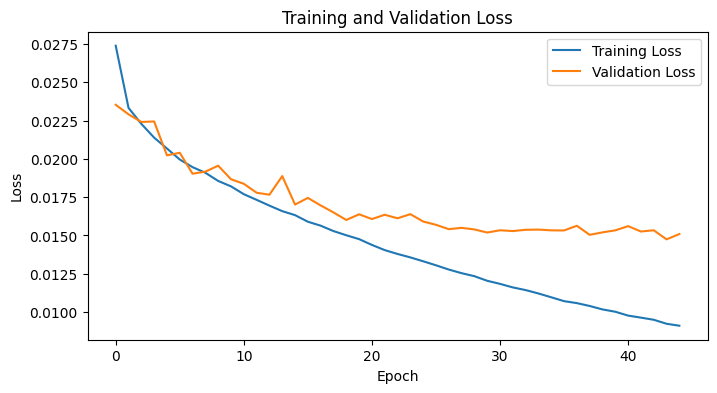

In [48]:
plt.figure(figsize=(8,4))
plt.plot(train_losses[:45], label='Training Loss')
plt.plot(val_losses[:45], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

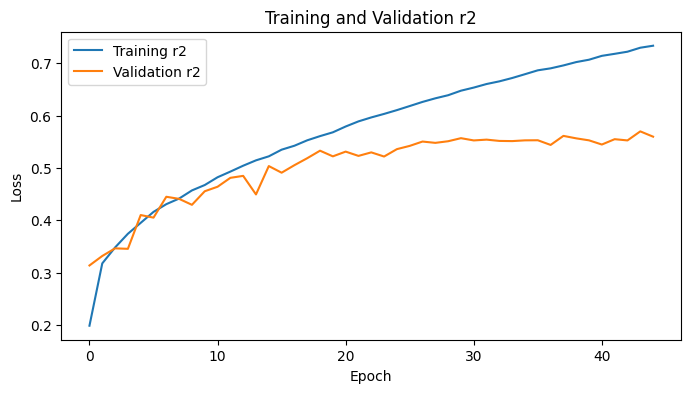

In [49]:
plt.figure(figsize=(8, 4))
plt.plot(train_r2_list[:45], label='Training r2')
plt.plot(val_r2_list[:45], label='Validation r2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation r2')
plt.legend()

Load best Model

In [29]:
model_dim = 320
num_heads = 8
num_layers = 2
dropout = 0.1
max_len = 39
ffdim = 256
model = SequenceModel(model_dim, num_heads, num_layers,ffdim,dropout=dropout).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4 ,weight_decay=0.0015724491637962514)

model.load_state_dict(torch.load('/kaggle/input/pepesmhuber/pytorch/default/1/pepesmclshyperparamtunedhuberloss.pth'))

<ipython-input-29-097a687b7c4c>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/pepesmhuber/pytorch/default/1/pepesmclshype

<All keys matched successfully>

Train Loss: 0.0069
Train R^2: 0.7970
Train MSE: 0.0139
Train MAE: 0.0908
Train RMSE: 0.3013


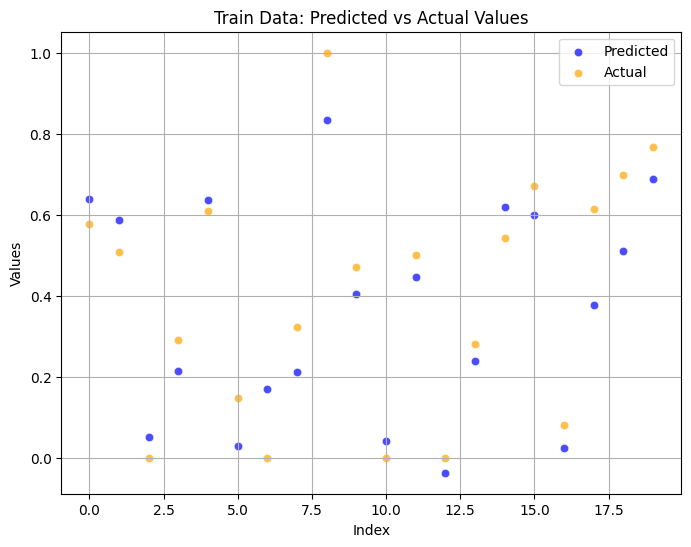

In [32]:
model.eval()
train_loss = 0
train_scores = []
train_predictions = []

with torch.no_grad():
    for pep_ids,mhc_ids, scores in train_loader:
        # Move tensors to the appropriate device
        pep_ids,mhc_ids, scores=pep_ids.to(device),mhc_ids.to(device), scores.to(device)
        outputs = model(pep_ids,mhc_ids)

        # Append labels and predictions to lists
        train_scores.extend(scores.cpu().numpy())
        train_predictions.extend(outputs.cpu().numpy().flatten())

        # Compute loss
        loss = criterion(outputs.squeeze(), scores)
        train_loss += loss.item()

# Compute average test loss
train_loss /= len(train_loader)

# Convert lists to numpy arrays
train_scores = np.array(train_scores)
train_predictions = np.array(train_predictions)
train_mse = mean_squared_error(train_scores,train_predictions)
train_mae = mean_absolute_error(train_scores,train_predictions)
train_rmse = np.sqrt(train_mae)

# Calculate R^2
train_r2 = r2_score(train_scores, train_predictions)
print(f"Train Loss: {train_loss:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")

train_data = pd.DataFrame({
    'Index': np.arange(len(train_predictions[:20])),
    'Predicted': train_predictions[:20],
    'Actual': train_scores[:20]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=train_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Train Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()

validation Loss: 0.0147
validation R^2: 0.5700
validation MSE: 0.0295
validation MAE: 0.1302
validation RMSE: 0.3608


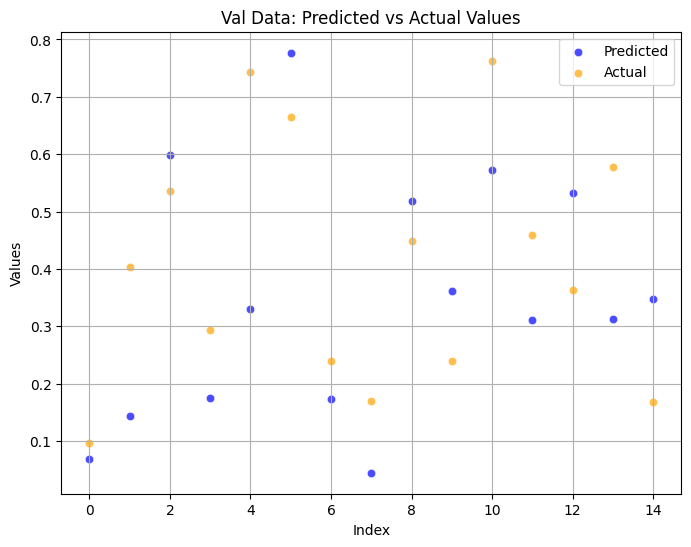

In [33]:
model.eval()
validation_loss = 0
validation_scores = []
validation_predictions = []

with torch.no_grad():
    for pep_ids,mhc_ids, scores in val_loader:
        # Move tensors to the appropriate device
        pep_ids,mhc_ids, scores=pep_ids.to(device),mhc_ids.to(device), scores.to(device)
        outputs = model(pep_ids,mhc_ids)

        # Append labels and predictions to lists
        validation_scores.extend(scores.cpu().numpy())
        validation_predictions.extend(outputs.cpu().numpy().flatten())

        # Compute loss
        loss = criterion(outputs.squeeze(), scores)
        validation_loss += loss.item()

validation_loss /= len(val_loader)

# Convert lists to numpy arrays
validation_scores = np.array(validation_scores)
validation_predictions = np.array(validation_predictions)
validation_mse = mean_squared_error(validation_scores,validation_predictions)
validation_mae = mean_absolute_error(validation_scores,validation_predictions)
validation_rmse = np.sqrt(validation_mae)

# Calculate R^2
validation_r2 = r2_score(validation_scores, validation_predictions)
print(f"validation Loss: {validation_loss:.4f}")
print(f"validation R^2: {validation_r2:.4f}")
print(f"validation MSE: {validation_mse:.4f}")
print(f"validation MAE: {validation_mae:.4f}")
print(f"validation RMSE: {validation_rmse:.4f}")

val_data = pd.DataFrame({
    'Index': np.arange(len(validation_predictions[:15])),
    'Predicted': validation_predictions[:15],
    'Actual': validation_scores[:15]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=val_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=val_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Val Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()


Test Loss: 0.0145
Test R^2: 0.5788
Test MSE: 0.0290
Test MAE: 0.1285
Test RMSE: 0.3585


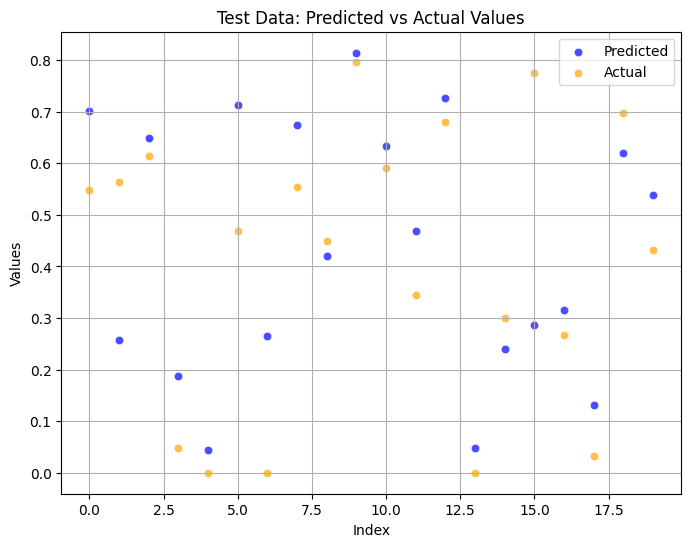

In [34]:
# Set the model to evaluation mode
model.eval()
test_loss = 0
test_scores = []
test_predictions = []

with torch.no_grad():
    for pep_ids, mhc_ids, scores in test_loader:
        # Move tensors to the appropriate device
        pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
        outputs = model(pep_ids, mhc_ids)

        # Append labels and predictions to lists
        test_scores.extend(scores.cpu().numpy())
        test_predictions.extend(outputs.cpu().numpy().flatten())

        # Compute loss
        loss = criterion(outputs.squeeze(), scores)
        test_loss += loss.item()

# Compute average test loss
test_loss /= len(test_loader)

# Convert lists to numpy arrays
test_scores = np.array(test_scores)
test_predictions = np.array(test_predictions)
test_mse = mean_squared_error(test_scores, test_predictions)
test_mae = mean_absolute_error(test_scores, test_predictions)
test_rmse = np.sqrt(test_mae)

# Calculate R^2
test_r2 = r2_score(test_scores, test_predictions)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Plotting Predicted vs Actual Values
test_data = pd.DataFrame({
    'Index': np.arange(len(test_predictions[20:40])),
    'Predicted': test_predictions[20:40],
    'Actual': test_scores[20:40]
})
plt.figure(figsize=(8, 6))
sns.scatterplot(data=test_data, x='Index', y='Predicted', color='blue', label='Predicted', alpha=0.7)
sns.scatterplot(data=test_data, x='Index', y='Actual', color='orange', label='Actual', alpha=0.7)

plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Test Data: Predicted vs Actual Values")
plt.legend()
plt.grid(True)
plt.show()


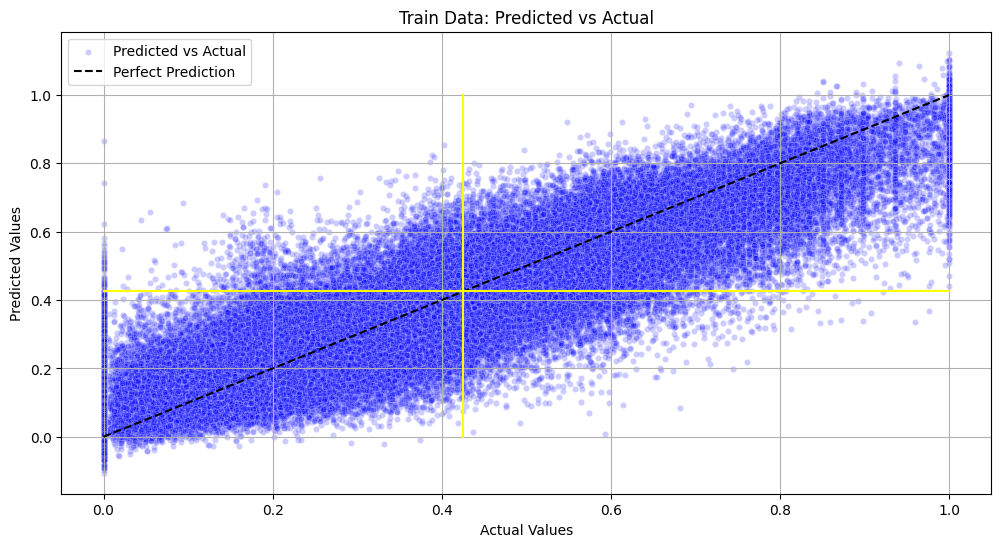

In [35]:
train_data = pd.DataFrame({
    'Predicted': train_predictions,
    'Actual': train_scores
})
plt.figure(figsize=(12, 6))
sns.scatterplot(x=train_data['Actual'], y=train_data['Predicted'], color='blue', s=20, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(train_data['Actual']), max(train_data['Actual'])], [min(train_data['Actual']), max(train_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='yellow',)
plt.plot([0,1],[0.4256,0.4256],color='yellow')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Train Data: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

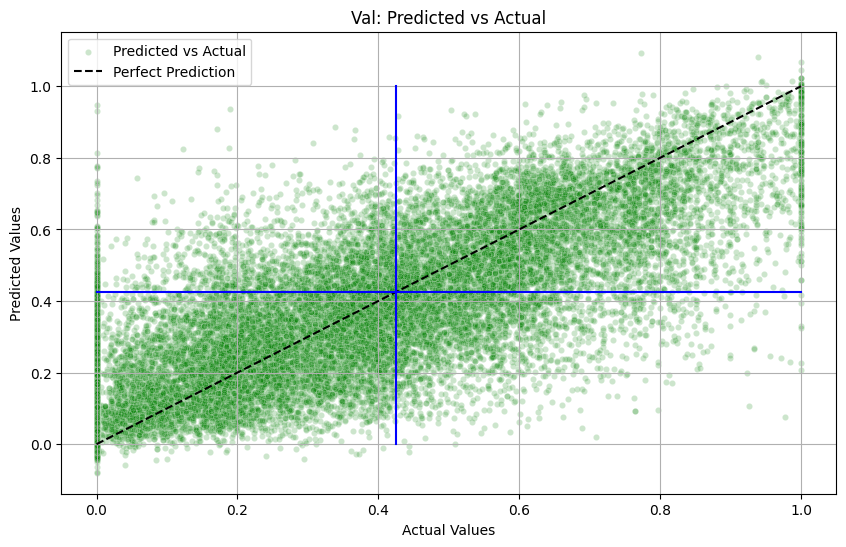

In [74]:
val_data = pd.DataFrame({
    'Predicted':validation_predictions,
    'Actual': validation_scores
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_data['Actual'], y=val_data['Predicted'], color='green', s=20, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(val_data['Actual']), max(val_data['Actual'])], [min(val_data['Actual']), max(val_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Val: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

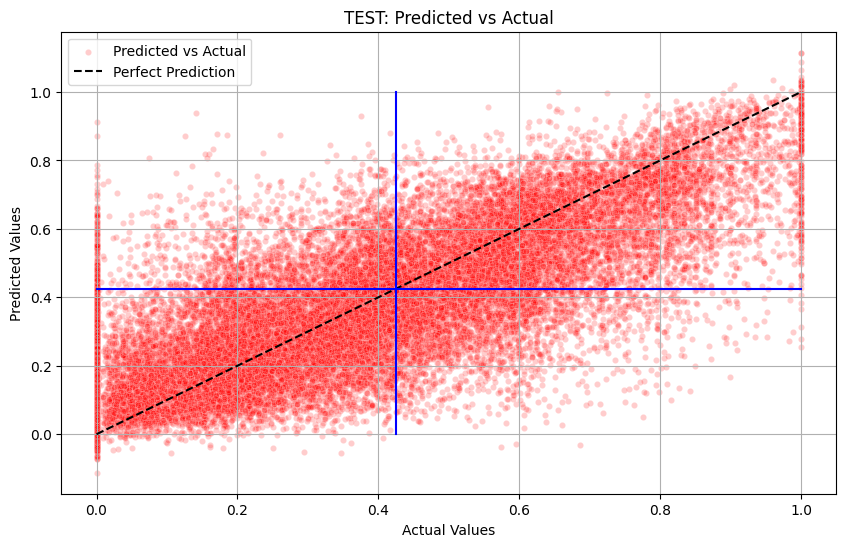

In [71]:
test_data = pd.DataFrame({
    'Predicted':test_predictions,
    'Actual': test_scores
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['Actual'], y=test_data['Predicted'], color='red', s=20, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
threshold = 0.4256

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


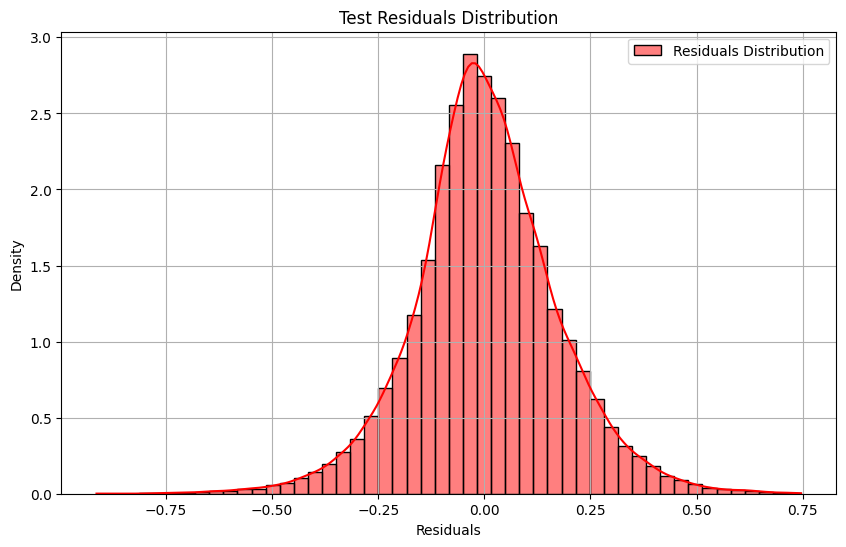

In [63]:
residuals = test_scores - test_predictions
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='red', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


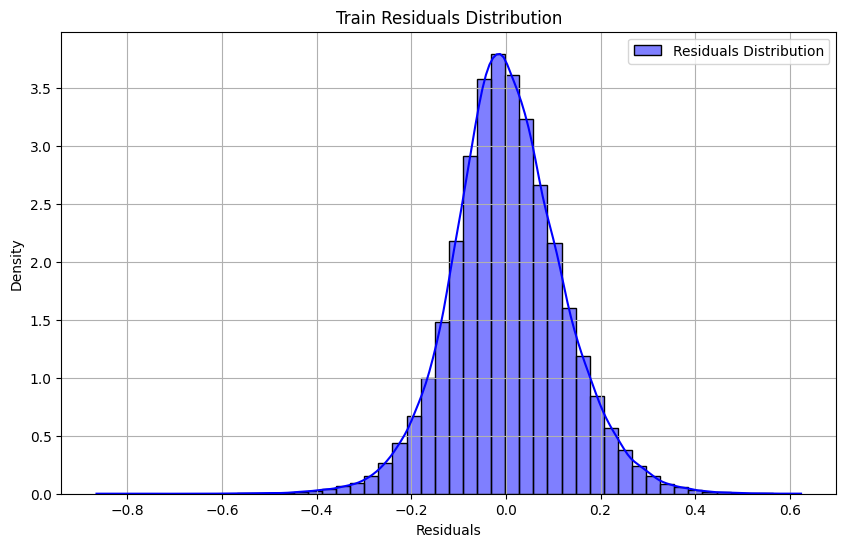

In [77]:
train_residuals = train_scores - train_predictions
plt.figure(figsize=(10, 6))
sns.histplot(train_residuals, kde=True, color='blue', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Train Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


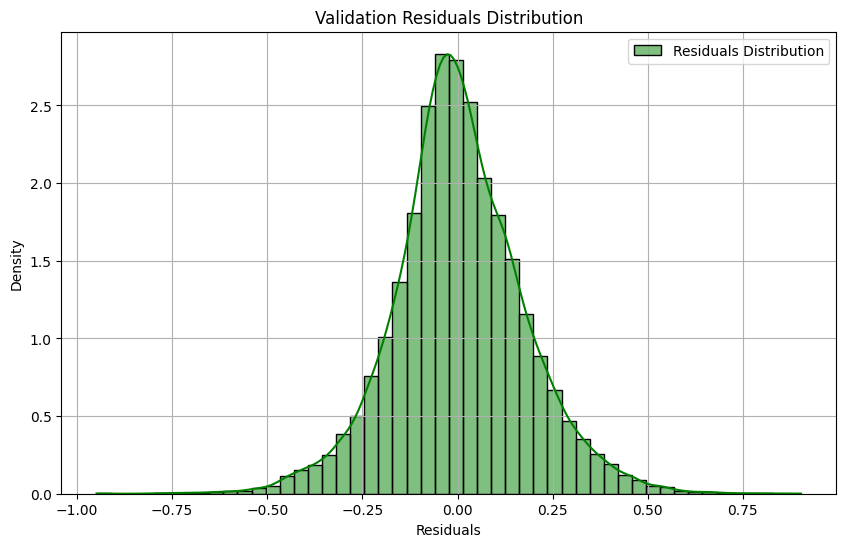

In [81]:
val_residuals = validation_scores - validation_predictions
plt.figure(figsize=(10, 6))
sns.histplot(val_residuals, kde=True, color='green', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Validation Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


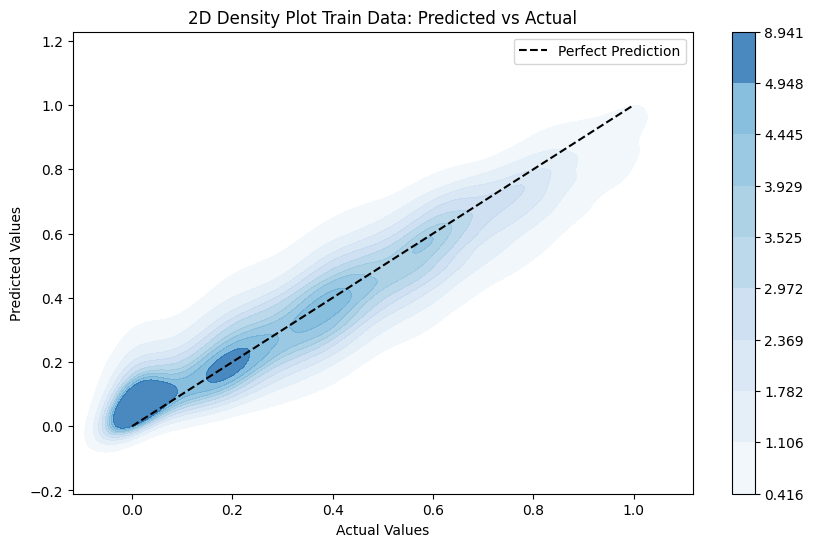

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_predictions and test_scores are already defined
train_data = pd.DataFrame({
    'Predicted': train_predictions,
    'Actual': train_scores
})

# Create the 2D density plot
plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=train_data['Actual'],
    y=train_data['Predicted'],
    cmap="Blues",  # Adjust the colormap
    fill=True,     # Fill the contours
    levels=10,     # Number of levels for contouring
    alpha=0.8,     # Transparency of the filled regions
    cbar=True      # Add the color bar
)

# Add threshold lines
plt.plot([min(train_data['Actual']), max(train_data['Actual'])], [min(train_data['Actual']), max(train_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')

# Add labels, title, and legend
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Train Data: Predicted vs Actual")
plt.legend()

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


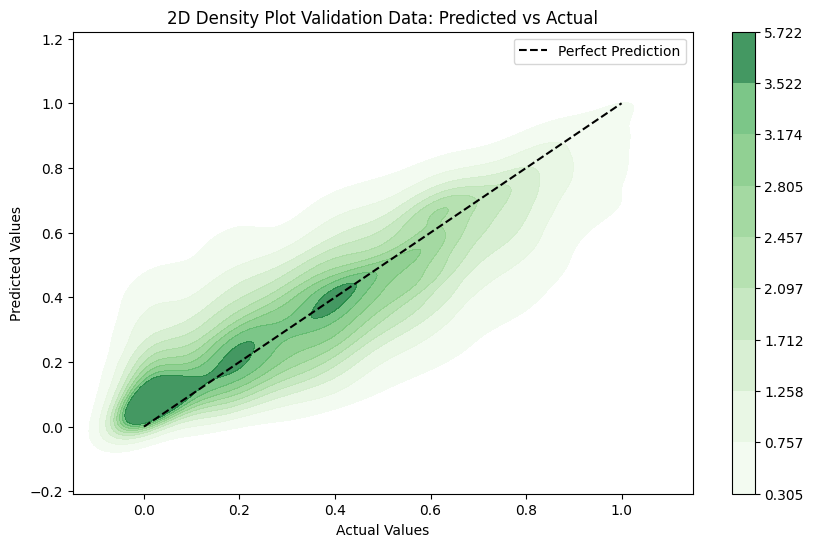

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_predictions and test_scores are already defined
val_data = pd.DataFrame({
    'Predicted': validation_predictions,
    'Actual': validation_scores
})

# Create the 2D density plot
plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=val_data['Actual'],
    y=val_data['Predicted'],
    cmap="Greens",  # Adjust the colormap
    fill=True,     # Fill the contours
    levels=10,     # Number of levels for contouring
    alpha=0.8,     # Transparency of the filled regions
    cbar=True      # Add the color bar
)

# Add threshold lines
plt.plot([min(val_data['Actual']), max(val_data['Actual'])], [min(val_data['Actual']), max(val_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')

# Add labels, title, and legend
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Validation Data: Predicted vs Actual")
plt.legend()

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


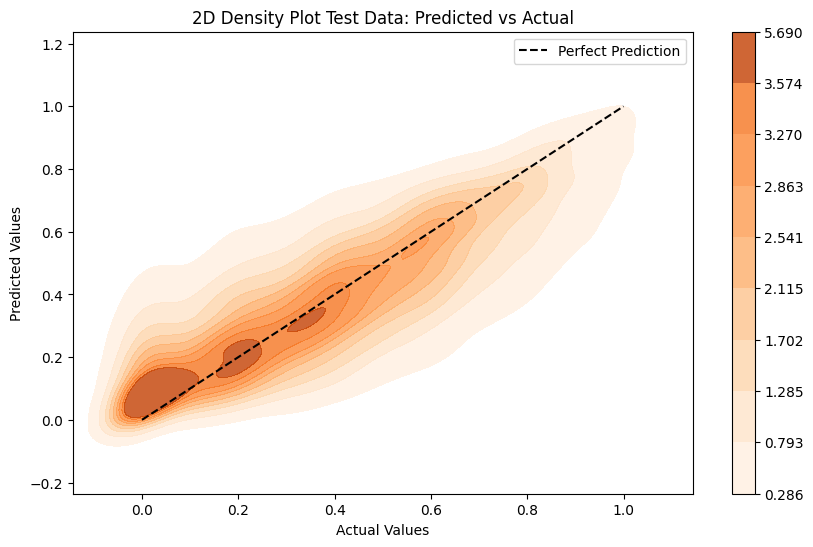

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_predictions and test_scores are already defined
test_data = pd.DataFrame({
    'Predicted': test_predictions,
    'Actual': test_scores
})

# Create the 2D density plot
plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=test_data['Actual'],
    y=test_data['Predicted'],
    cmap="Oranges",  # Adjust the colormap
    fill=True,     # Fill the contours
    levels=10,     # Number of levels for contouring
    alpha=0.8,     # Transparency of the filled regions
    cbar=True      # Add the color bar
)

# Add threshold lines
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')

# Add labels, title, and legend
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()

# Show the plot
plt.show()


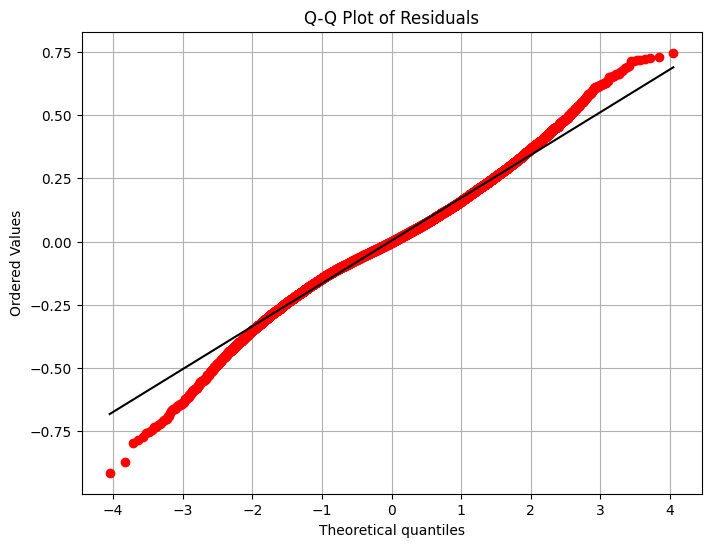

In [64]:
from scipy.stats import probplot

plt.figure(figsize=(8, 6))
qq_plot = probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.gca().get_lines()[0].set_color('red')
plt.gca().get_lines()[1].set_color('black')
plt.show()


K-Fold Cross Val

In [62]:
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_data)))):
    print(f"Starting Fold {fold + 1}/{k_folds}")

    # Train and validation subsets
    train_subset = Subset(train_data, train_idx)
    val_subset = Subset(train_data, val_idx)

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Model initialization
    model = SequenceModel(model_dim=320, num_heads=8, num_layers=2, ffdim=256, dropout=0.1).to(device)
    criterion = torch.nn.HuberLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.00157)

    best_val_r2 = -float("inf")
    patience_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total_train_preds, total_train_labels = [], []

        for pep_ids, mhc_ids, scores in train_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            optimizer.zero_grad()
            outputs = model(pep_ids, mhc_ids)
            loss = criterion(outputs.squeeze(), scores)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_train_preds.append(outputs.detach().cpu())
            total_train_labels.append(scores.detach().cpu())

        train_loss /= len(train_loader)
        train_preds = torch.cat(total_train_preds).numpy().flatten()
        train_labels = torch.cat(total_train_labels).numpy().flatten()

        # Compute training metrics
        train_r2 = r2_score(train_labels, train_preds)
        train_mse = mean_squared_error(train_labels, train_preds)
        train_rmse = np.sqrt(train_mse)
        train_mae = mean_absolute_error(train_labels, train_preds)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, R²: {train_r2:.4f}, "
              f"MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0
        total_val_preds, total_val_labels = [], []

        with torch.no_grad():
            for pep_ids, mhc_ids, scores in val_loader:
                pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
                outputs = model(pep_ids, mhc_ids)
                loss = criterion(outputs.squeeze(), scores)
                val_loss += loss.item()
                total_val_preds.append(outputs.cpu())
                total_val_labels.append(scores.cpu())

        val_loss /= len(val_loader)
        val_preds = torch.cat(total_val_preds).numpy().flatten()
        val_labels = torch.cat(total_val_labels).numpy().flatten()

        # Compute validation metrics
        val_r2 = r2_score(val_labels, val_preds)
        val_mse = mean_squared_error(val_labels, val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(val_labels, val_preds)

        print(f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, R²: {val_r2:.4f}, "
              f"MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}")

        # Save best model
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(save_dir, f"best_model_fold_{fold + 1}.pth"))
            print(f"Saved best model for fold {fold + 1} with R²: {best_val_r2:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"Completed Fold {fold + 1}/{k_folds}")


Starting Fold 1/5
Epoch 1, Train Loss: 0.0276, R²: 0.1922, MSE: 0.0552, RMSE: 0.2350, MAE: 0.1921
Epoch 1, Val Loss: 0.0245, R²: 0.2865, MSE: 0.0489, RMSE: 0.2212, MAE: 0.1799
Saved best model for fold 1 with R²: 0.2865
Epoch 2, Train Loss: 0.0237, R²: 0.3075, MSE: 0.0474, RMSE: 0.2176, MAE: 0.1757
Epoch 2, Val Loss: 0.0235, R²: 0.3161, MSE: 0.0469, RMSE: 0.2166, MAE: 0.1742
Saved best model for fold 1 with R²: 0.3161
Epoch 3, Train Loss: 0.0225, R²: 0.3424, MSE: 0.0450, RMSE: 0.2120, MAE: 0.1705
Epoch 3, Val Loss: 0.0219, R²: 0.3617, MSE: 0.0438, RMSE: 0.2092, MAE: 0.1677
Saved best model for fold 1 with R²: 0.3617
Epoch 4, Train Loss: 0.0215, R²: 0.3719, MSE: 0.0429, RMSE: 0.2072, MAE: 0.1659
Epoch 4, Val Loss: 0.0216, R²: 0.3703, MSE: 0.0432, RMSE: 0.2078, MAE: 0.1658
Saved best model for fold 1 with R²: 0.3703
Epoch 5, Train Loss: 0.0208, R²: 0.3919, MSE: 0.0416, RMSE: 0.2039, MAE: 0.1625
Epoch 5, Val Loss: 0.0203, R²: 0.4073, MSE: 0.0407, RMSE: 0.2016, MAE: 0.1592
Saved best model

In [64]:
models = []
for fold in range(1, 6):  # Assuming 5 folds
    model = SequenceModel(model_dim=320, num_heads=8, num_layers=2, ffdim=256, dropout=0.1).to(device)
    # Load weights with `weights_only=True`
    state_dict = torch.load(os.path.join(save_dir, f"best_model_fold_{fold}.pth"), weights_only=True)
    model.load_state_dict(state_dict)

    model.eval()
    models.append(model)


In [67]:
total_preds = []
total_labels = []

for model in models:
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    preds = []
    labels = []

    with torch.no_grad():
        for pep_ids, mhc_ids, scores in test_loader:
            pep_ids, mhc_ids, scores = pep_ids.to(device), mhc_ids.to(device), scores.to(device)
            outputs = model(pep_ids, mhc_ids)
            preds.append(outputs.cpu())
            labels.append(scores.cpu())

    total_preds.append(torch.cat(preds).numpy().flatten())
    total_labels.append(torch.cat(labels).numpy().flatten())

# Average predictions across folds
avg_preds = np.mean(total_preds, axis=0)
test_labels = total_labels[0]  # All labels are the same

# Compute metrics
test_r2 = r2_score(test_labels, avg_preds)
test_mse = mean_squared_error(test_labels, avg_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_labels, avg_preds)

print(f"Test R²: {test_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test R²: 0.6251
Test MSE: 0.0258
Test RMSE: 0.1606
Test MAE: 0.1218


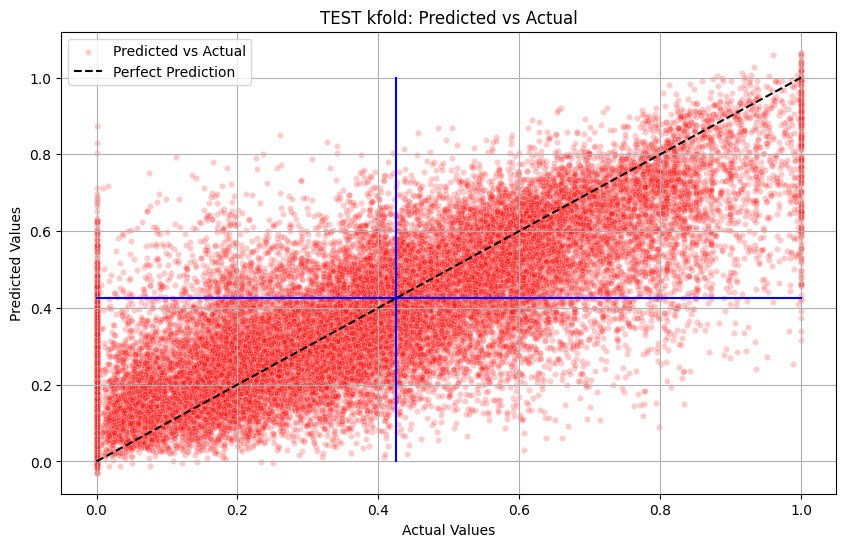

In [82]:
test_data = pd.DataFrame({
    'Predicted':avg_preds,
    'Actual': test_labels
})
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_data['Actual'], y=test_data['Predicted'], color='red', s=20, alpha=0.2, edgecolors='black', linewidth=0.5, label='Predicted vs Actual')
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')
plt.plot([0.4256,0.4256],[0,1],color='blue',)
plt.plot([0,1],[0.4256,0.4256],color='blue')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("TEST kfold: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


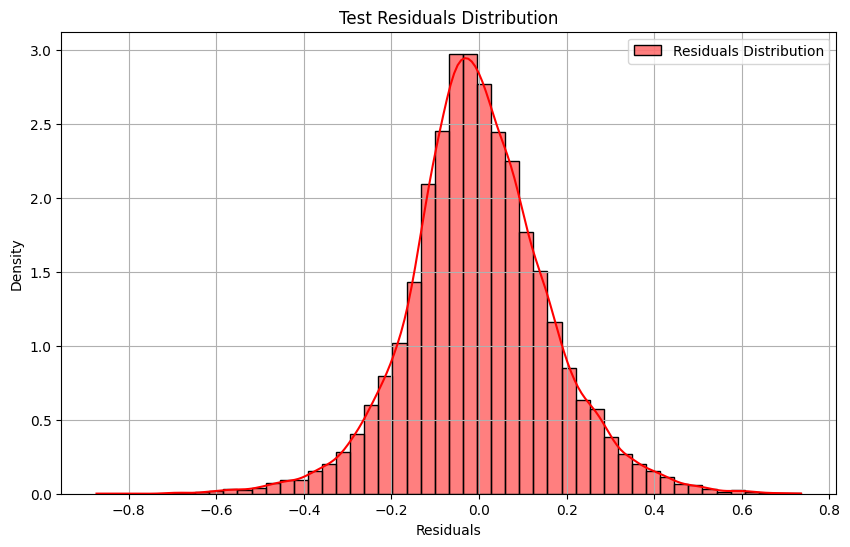

In [80]:
kfold_residuals = test_labels - avg_preds
plt.figure(figsize=(10, 6))
sns.histplot(kfold_residuals, kde=True, color='red', bins=50, stat='density', label='Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Test Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


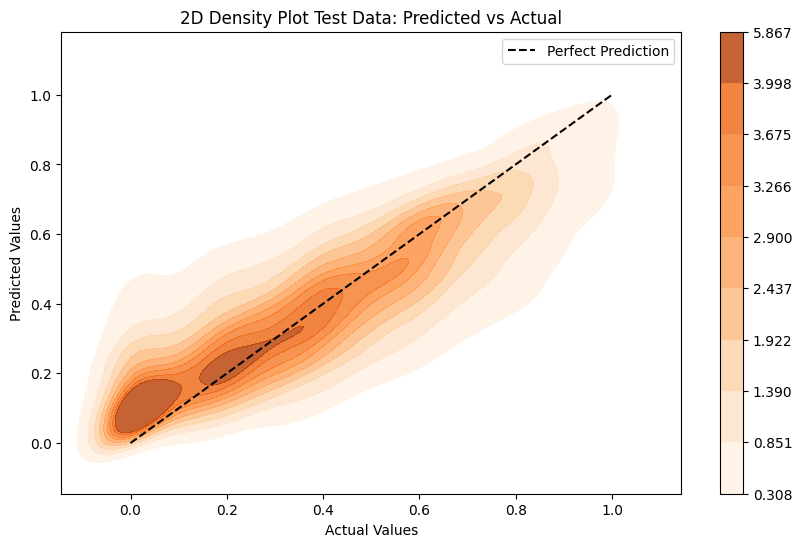

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming test_predictions and test_scores are already defined
test_data = pd.DataFrame({
    'Predicted': avg_preds,
    'Actual': test_labels
})

# Create the 2D density plot
plt.figure(figsize=(10, 6))
kde = sns.kdeplot(
    x=test_data['Actual'],
    y=test_data['Predicted'],
    cmap="Oranges",  # Adjust the colormap
    fill=True,     # Fill the contours
    levels=10,     # Number of levels for contouring
    alpha=0.8,     # Transparency of the filled regions
    cbar=True      # Add the color bar
)

# Add threshold lines
plt.plot([min(test_data['Actual']), max(test_data['Actual'])], [min(test_data['Actual']), max(test_data['Actual'])], color='black', linestyle='--', label='Perfect Prediction')

# Add labels, title, and legend
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("2D Density Plot Test Data: Predicted vs Actual")
plt.legend()

# Show the plot
plt.show()
